In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
import sys
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


# Data Cleaning

In [2]:
# import data from CSV file
raw_data = pd.read_csv('NFLCombineData.csv')
print(raw_data.shape)

(4945, 25)


In [3]:
# quick test, to see how many values are missing for a specific parameter
parameter = 'fortyyd'
raw_data_no_outlier = raw_data.loc[raw_data[parameter] > 0]
print("Number of Players' Data Missing for -->", "\b", parameter, ":", raw_data.shape[0]-raw_data_no_outlier.shape[0])

Number of Players' Data Missing for -->  fortyyd : 191


In [4]:
# combining positions based on related characterisitcs into groupings (6 classes)
    # 0: Running Backs: RB, FB
    # 1: Pass Catchers: WR, TE
    # 2: Defensive Backs: FS, SS, CB
    # 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
    # 4: Linebackers: ILB, OLB
    # 5: Quarterback + Special Team: QB, P, K
    
# create dictionary of metrics corresponding to index in data
pos_dict = {'year': 0, 'name': 1, 'firstname': 2, 'lastname': 3, 'position': 4, 'heightfeet': 5, 
            'heightinches': 6, 'heightinchestotal': 7, 'weight': 8, 'arms': 9, 'hands': 10,
            'fortyyd': 11, 'twentyyd': 12, 'tenyd': 13, 'twentyss': 14, 'threecone': 15, 
            'vertical': 16, 'broad': 17, 'bench': 18, 'round': 19, 'college': 20, 
            'pickround': 21, 'picktotal': 22, 'wonderlic': 23, 'nflgrade': 24}

# extract all players (stored by position) from raw_data
rb = (raw_data.loc[raw_data['position'] == 'RB']).to_numpy()
fb = (raw_data.loc[raw_data['position'] == 'FB']).to_numpy()
wr = (raw_data.loc[raw_data['position'] == 'WR']).to_numpy()
te = (raw_data.loc[raw_data['position'] == 'TE']).to_numpy()
fs = (raw_data.loc[raw_data['position'] == 'FS']).to_numpy()
ss = (raw_data.loc[raw_data['position'] == 'SS']).to_numpy()
cb = (raw_data.loc[raw_data['position'] == 'CB']).to_numpy()
ot = (raw_data.loc[raw_data['position'] == 'OT']).to_numpy()
og = (raw_data.loc[raw_data['position'] == 'OG']).to_numpy()
oc = (raw_data.loc[raw_data['position'] == 'OC']).to_numpy()
c = (raw_data.loc[raw_data['position'] == 'C']).to_numpy()
nt = (raw_data.loc[raw_data['position'] == 'NT']).to_numpy()
dt = (raw_data.loc[raw_data['position'] == 'DT']).to_numpy()
de = (raw_data.loc[raw_data['position'] == 'DE']).to_numpy()
ls = (raw_data.loc[raw_data['position'] == 'LS']).to_numpy()
ilb = (raw_data.loc[raw_data['position'] == 'ILB']).to_numpy()
olb = (raw_data.loc[raw_data['position'] == 'OLB']).to_numpy()
qb = (raw_data.loc[raw_data['position'] == 'QB']).to_numpy()
p = (raw_data.loc[raw_data['position'] == 'P']).to_numpy()
k = (raw_data.loc[raw_data['position'] == 'K']).to_numpy()

# concatenate similar positions based on the classification of groups (detailed above)
run_back = np.concatenate((rb, fb))
print(len(run_back))
pass_catch = np.concatenate((wr, te))
print(len(pass_catch))
defense_back = np.concatenate((fs, ss, cb))
print(len(defense_back))
linemen = np.concatenate((ot, og, oc, c, nt, dt, de, ls))
print(len(linemen))
lineback = np.concatenate((ilb, olb))
print(len(lineback))
quarterback_special = np.concatenate((qb, p, k))
print(len(quarterback_special))

557
922
885
1668
588
325


# Basic Preprocessing (no normalization or zero-meaning)

In [5]:
# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

def simple_preprocess_data(position, index):
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            rowArr.append(stat)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        
        
# 0: Running Backs: RB, FB
simple_preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
simple_preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
simple_preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
simple_preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
simple_preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
simple_preprocess_data(quarterback_special, 5)
    
c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)
print(data_players)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled

# ALL GOOD SO FAR

[[207.     73.      0.      0.      0.   ]
 [315.     76.    105.      5.07   24.   ]
 [307.     77.    109.      5.     18.   ]
 [200.     71.    108.      4.6    17.   ]
 [232.     71.    113.      4.59   29.   ]
 [306.     74.      0.      5.      0.   ]
 [309.     78.    111.      5.17   23.   ]
 [242.     79.      0.      0.      0.   ]
 [194.     73.    113.      4.71    0.   ]
 [248.     75.    118.      4.64    0.   ]
 [178.     70.    120.      4.53    0.   ]
 [320.     77.    100.      5.37   24.   ]
 [201.     77.    110.      4.47    0.   ]
 [205.     74.    129.      4.66    0.   ]
 [222.     71.      0.      4.71   18.   ]
 [222.     74.      0.      4.76    0.   ]
 [252.     75.      0.      0.      0.   ]
 [192.     71.      0.      4.49   18.   ]
 [327.     74.     96.      5.19   27.   ]
 [208.     73.    119.      4.58   11.   ]
 [203.     71.    125.      4.4    25.   ]
 [323.     78.     97.      5.4    31.   ]
 [320.     77.    106.      5.42   26.   ]
 [312.     

In [6]:

model = keras.Sequential()
model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#odel.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Simple data -> Softmax model

In [7]:
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 46us/step - loss: 63.4353 - accuracy: 0.3033 - val_loss: 42.8225 - val_accuracy: 0.2861
Epoch 2/100
3956/3956 [==============================] - 0s 22us/step - loss: 32.4701 - accuracy: 0.3286 - val_loss: 22.9977 - val_accuracy: 0.2963
Epoch 3/100
3956/3956 [==============================] - 0s 20us/step - loss: 17.9902 - accuracy: 0.3428 - val_loss: 12.1207 - val_accuracy: 0.3246
Epoch 4/100
3956/3956 [==============================] - 0s 22us/step - loss: 9.5290 - accuracy: 0.4221 - val_loss: 8.4739 - val_accuracy: 0.4681
Epoch 5/100
3956/3956 [==============================] - 0s 20us/step - loss: 8.3219 - accuracy: 0.4676 - val_loss: 7.7780 - val_accuracy: 0.4853
Epoch 6/100
3956/3956 [==============================] - 0s 21us/step - loss: 7.6455 - accuracy: 0.4818 - val_loss: 7.1393 - val_accuracy: 0.4793
Epoch 7/100
3956/3956 [==============================] - 0s 22us/step -

3956/3956 [==============================] - 0s 23us/step - loss: 0.9444 - accuracy: 0.5880 - val_loss: 0.9608 - val_accuracy: 0.5925
Epoch 57/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.9231 - accuracy: 0.5993 - val_loss: 0.9647 - val_accuracy: 0.5410
Epoch 58/100
3956/3956 [==============================] - 0s 20us/step - loss: 0.9324 - accuracy: 0.5950 - val_loss: 0.9532 - val_accuracy: 0.5632
Epoch 59/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.9301 - accuracy: 0.5963 - val_loss: 0.9726 - val_accuracy: 0.5642
Epoch 60/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.9349 - accuracy: 0.6019 - val_loss: 0.9478 - val_accuracy: 0.5885
Epoch 61/100
3956/3956 [==============================] - 0s 20us/step - loss: 0.9473 - accuracy: 0.5913 - val_loss: 0.9713 - val_accuracy: 0.5774
Epoch 62/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.9303 - accuracy: 0.6031 - val_loss: 0.9512 - val_a

Text(0.5, 1.0, 'accuracy')

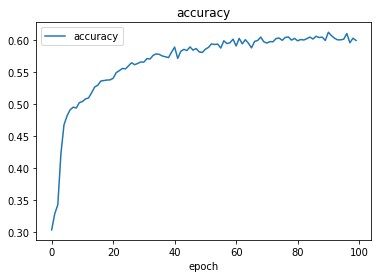

In [8]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

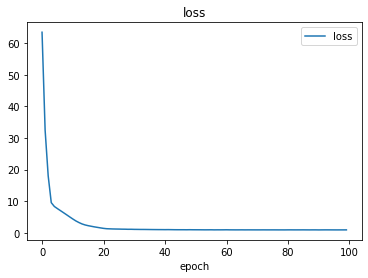

In [9]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

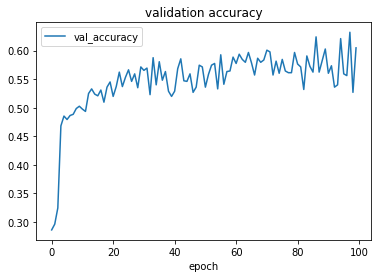

In [10]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [11]:
#Very low to begin with and decreases over time

Text(0.5, 1.0, 'validation loss')

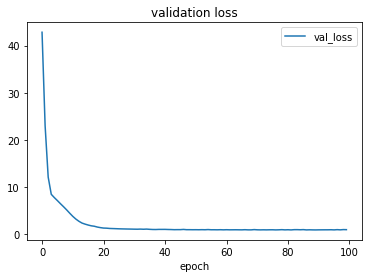

In [12]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

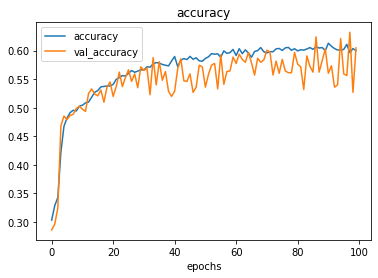

In [13]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [14]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [5 3 3 2 4 3 3 5 1 4 2 3 2 1 4 5 4 2 3 1 2 3 3 3 3 0 3 2 5 4 3 2 3 4 2 0 1
 2 3 3 0 4 2 1 4 2 4 4 3 4 4 0 3 2 4 4 3 3 5 4 4 3 3 4 0 4 3 2 0 3 3 3 3 0
 3 2 1 3 1 3 0 3 3 4 2 3 3 2 2 4 4 4 4 3 1 2 3 2 4 4 3 2 2 4 3 2 3 4 3 4 4
 3 3 2 3 3 0 2 4 2 0 4 4 4 4 4 3 4 2 3 3 3 4 3 2 1 0 3 2 2 4 4 5 2 1 3 1 0
 3 2 3 3 4 0 2 2 2 3 2 2 4 2 4 2 3 4 2 3 3 3 3 4 4 3 2 0 3 1 3 1 3 4 3 2 3
 1 3 0 4 4 1 4 2 2 2 4 3 1 3 1 3 2 4 3 4 4 4 3 0 2 3 4 1 4 0 2 4 4 2 4 2 3
 0 4 4 3 4 0 2 4 2 3 1 2 4 4 4 4 3 4 3 4 2 2 4 4 2 3 1 3 0 1 3 4 3 4 4 0 1
 5 1 4 2 3 4 3 1 3 1 1 2 2 1 2 3 2 3 2 2 3 3 1 0 4 1 2 1 4 4 2 2 3 3 4 3 2
 4 3 2 3 3 3 3 4 4 3 3 4 3 3 4 0 3 4 4 2 4 1 3 4 2 4 4 0 3 4 0 3 3 2 4 3 3
 2 3 3 2 4 4 3 3 1 2 3 3 1 3 3 4 4 2 3 1 2 2 3 3 2 2 2 3 1 2 3 3 0 0 2 3 4
 3 0 4 3 0 4 2 2 3 4 3 3 3 0 3 0 1 1 4 5 0 3 5 4 2 3 3 1 1 4 1 2 2 1 2 4 2
 3 2 3 3 1 4 4 4 4 2 4 3 4 3 2 4 3 2 2 3 4 4 2 2 3 2 4 2 2 4 4 3 4 4 4 3 2
 4 3 1 3 1 4 1 4 2 3 0 1 0 2 5 3 3 3 3 2 4 2 2 1 3 3 2 2 3 2 3 2 3 3 4 2 1
 3 2 3

# Simple Data -> ReLU + Softmax model

In [15]:
#TRYING DIFFERENT MODEL

In [16]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 49us/step - loss: 22.3324 - accuracy: 0.2376 - val_loss: 2.2746 - val_accuracy: 0.3185
Epoch 2/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.7322 - accuracy: 0.3809 - val_loss: 1.5571 - val_accuracy: 0.3721
Epoch 3/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.4663 - accuracy: 0.4340 - val_loss: 1.4535 - val_accuracy: 0.4186
Epoch 4/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.3929 - accuracy: 0.4639 - val_loss: 1.4056 - val_accuracy: 0.4307
Epoch 5/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.3536 - accuracy: 0.4636 - val_loss: 1.3697 - val_accuracy: 0.4661
Epoch 6/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.3312 - accuracy: 0.4800 - val_loss: 1.3624 - val_accuracy: 0.4772
Epoch 7/100
3956/3956 [==============================] - 0s 30us/step - loss

3956/3956 [==============================] - 0s 22us/step - loss: 1.2787 - accuracy: 0.5043 - val_loss: 1.3138 - val_accuracy: 0.4894
Epoch 57/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.2003 - accuracy: 0.5197 - val_loss: 1.1693 - val_accuracy: 0.5126
Epoch 58/100
3956/3956 [==============================] - 0s 21us/step - loss: 1.1008 - accuracy: 0.5293 - val_loss: 1.1198 - val_accuracy: 0.5511
Epoch 59/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.0849 - accuracy: 0.5402 - val_loss: 1.1045 - val_accuracy: 0.5551
Epoch 60/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.0822 - accuracy: 0.5321 - val_loss: 1.1104 - val_accuracy: 0.5308
Epoch 61/100
3956/3956 [==============================] - 0s 21us/step - loss: 1.0627 - accuracy: 0.5508 - val_loss: 1.1212 - val_accuracy: 0.5339
Epoch 62/100
3956/3956 [==============================] - 0s 21us/step - loss: 1.0601 - accuracy: 0.5369 - val_loss: 1.1120 - val_a

In [17]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

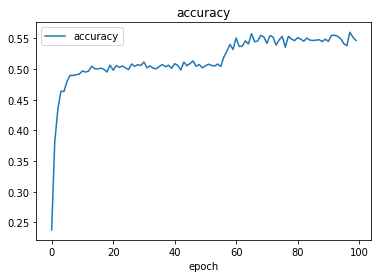

In [18]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

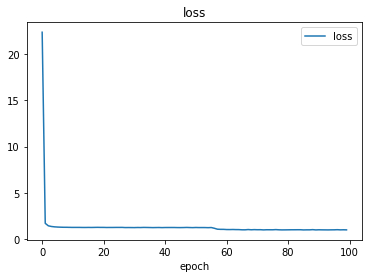

In [19]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

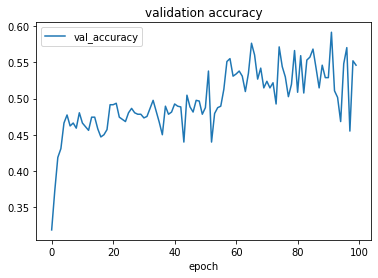

In [20]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [21]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

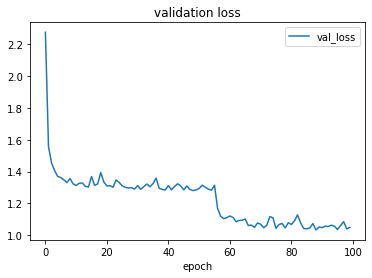

In [22]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

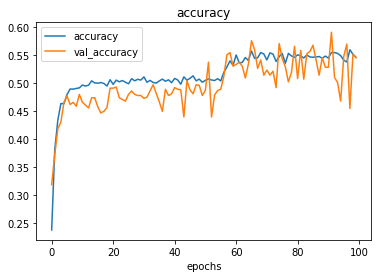

In [23]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [24]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [2 3 3 2 4 3 3 1 2 4 2 3 2 2 1 1 4 2 3 2 1 3 3 3 3 1 3 2 2 4 3 2 3 4 2 1 2
 2 3 3 1 4 1 1 4 2 4 4 3 4 4 1 3 1 4 4 3 3 2 4 4 3 3 3 1 4 3 2 1 3 3 3 3 1
 3 2 1 3 2 3 1 3 3 3 2 3 3 2 2 4 4 4 1 3 2 2 3 1 4 3 3 1 2 4 3 2 3 1 3 3 4
 3 3 2 3 3 1 2 4 2 1 4 4 4 4 4 3 3 2 3 3 3 1 3 2 2 1 3 2 2 3 4 1 1 1 3 1 1
 3 2 3 3 4 1 2 2 2 3 2 1 3 2 4 2 3 4 2 3 3 3 3 4 3 3 2 1 3 2 3 2 3 1 3 2 3
 2 3 1 1 4 1 4 2 2 1 4 3 1 3 1 3 1 3 3 1 3 1 3 1 2 3 4 2 3 1 2 4 4 2 1 1 3
 1 4 4 3 1 1 2 3 2 3 1 2 3 4 4 4 3 1 3 4 2 2 4 4 2 3 2 3 1 2 3 3 3 3 4 1 1
 2 1 3 2 3 4 3 2 3 2 2 2 2 1 2 3 2 3 2 2 3 3 2 1 3 1 2 1 1 4 2 2 3 3 4 3 1
 4 3 2 3 3 3 3 4 4 3 3 4 3 3 4 1 3 4 4 2 4 2 3 1 1 4 3 1 3 3 1 3 3 2 4 3 3
 1 3 3 2 4 4 3 3 2 2 3 3 2 3 3 3 4 2 3 1 2 2 3 3 2 2 2 3 1 2 3 3 1 1 2 3 4
 3 1 4 3 1 4 2 2 3 4 3 3 3 1 3 1 2 2 3 1 1 3 1 4 2 3 3 2 2 4 2 2 2 2 2 4 2
 3 2 3 3 2 4 1 4 1 2 4 3 4 3 2 3 3 2 2 3 1 4 2 1 3 2 4 2 1 3 4 3 4 3 4 3 2
 1 3 1 3 2 1 1 4 2 3 1 1 1 2 2 3 3 3 3 2 1 2 2 2 3 3 1 1 3 1 3 2 3 3 3 2 2
 3 2 3

# Zero-meaning and normalizing data for a select few combine events

In [25]:
#This time zero-meaning and normalizing player vectors

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)
print(data_players)


# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

[[-9.99716676e-01 -4.27394508e-03 -9.16744732e-03 -1.62561358e-03
   2.14852686e-02]
 [-3.69729101e-01 -7.20664614e-02 -8.31680355e-01 -5.38757011e-03
  -4.07903884e-01]
 [ 3.75019998e-01  7.80445741e-03  9.25689081e-01  1.20617564e-03
   4.89628585e-02]
 [ 3.49217643e-01  3.18606436e-02 -6.81191549e-01  3.07496601e-02
  -6.41922479e-01]
 [-9.98182461e-01 -2.65740122e-02 -3.09584873e-02 -1.98303778e-04
  -4.43523356e-02]
 [ 3.36419033e-02  2.73652099e-02  9.97771265e-01  4.07233736e-02
   3.02237813e-02]
 [-2.04960881e-01 -1.48760822e-02  9.77906630e-01 -1.81867809e-04
  -3.83187781e-02]
 [-9.29248983e-01 -1.62476318e-01  2.56735977e-01 -1.94014421e-02
  -2.09303599e-01]
 [ 9.77926680e-01 -8.61143387e-02 -1.87100451e-02  2.06736300e-02
  -1.88324893e-01]
 [-9.71595600e-01 -1.00800862e-01  1.79311898e-01 -1.44504105e-02
  -1.16101700e-01]
 [-5.11449411e-01  9.48310812e-03  5.74095776e-01 -3.88946340e-03
   6.39318765e-01]
 [-8.19681404e-01 -1.29537528e-01  5.21419555e-01 -2.20922749e-02

# Fancy data -> ReLu + Softmax model

In [26]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 47us/step - loss: 1.6660 - accuracy: 0.3332 - val_loss: 1.6254 - val_accuracy: 0.3205
Epoch 2/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.5852 - accuracy: 0.3723 - val_loss: 1.5809 - val_accuracy: 0.3721
Epoch 3/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.5604 - accuracy: 0.3814 - val_loss: 1.5668 - val_accuracy: 0.3771
Epoch 4/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.5509 - accuracy: 0.3756 - val_loss: 1.5617 - val_accuracy: 0.3802
Epoch 5/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.5418 - accuracy: 0.3873 - val_loss: 1.5519 - val_accuracy: 0.3832
Epoch 6/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.5347 - accuracy: 0.3852 - val_loss: 1.5507 - val_accuracy: 0.3832
Epoch 7/100
3956/3956 [==============================] - 0s 23us/step - loss:

3956/3956 [==============================] - 0s 21us/step - loss: 1.4864 - accuracy: 0.4163 - val_loss: 1.5272 - val_accuracy: 0.4004
Epoch 57/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.4862 - accuracy: 0.4194 - val_loss: 1.5195 - val_accuracy: 0.3943
Epoch 58/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.4864 - accuracy: 0.4148 - val_loss: 1.5212 - val_accuracy: 0.4055
Epoch 59/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.4842 - accuracy: 0.4206 - val_loss: 1.5313 - val_accuracy: 0.4034
Epoch 60/100
3956/3956 [==============================] - 0s 21us/step - loss: 1.4853 - accuracy: 0.4232 - val_loss: 1.5311 - val_accuracy: 0.3913
Epoch 61/100
3956/3956 [==============================] - 0s 21us/step - loss: 1.4855 - accuracy: 0.4214 - val_loss: 1.5169 - val_accuracy: 0.4004
Epoch 62/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.4861 - accuracy: 0.4171 - val_loss: 1.5130 - val_a

In [27]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

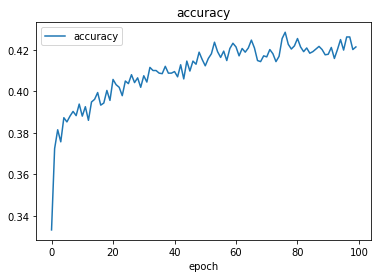

In [28]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

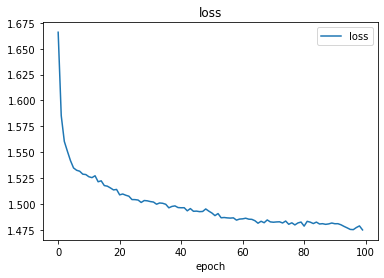

In [29]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

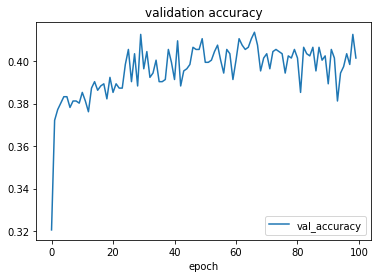

In [30]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [31]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

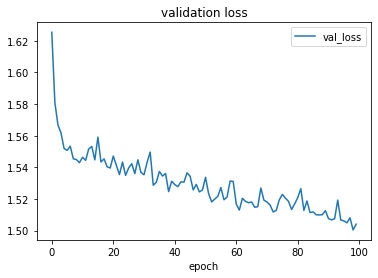

In [32]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

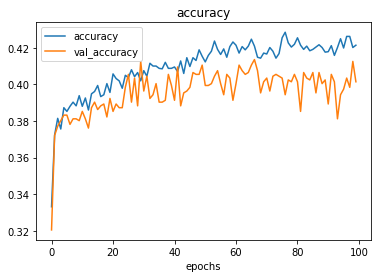

In [33]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [34]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [3 2 3 3 1 3 3 3 3 3 1 3 3 3 5 3 2 1 3 3 3 1 1 1 3 3 2 1 1 3 1 2 3 1 1 3 2
 1 3 3 3 3 1 3 1 3 3 1 5 3 1 5 3 1 2 2 1 3 3 5 5 3 5 3 3 1 1 3 2 1 3 3 3 5
 1 3 1 3 3 1 3 3 3 1 1 1 2 1 3 5 3 1 3 3 1 5 2 3 2 1 2 3 3 3 2 3 3 1 3 1 3
 3 3 2 3 2 3 3 5 1 3 1 3 5 5 3 1 3 5 3 2 1 1 3 3 3 1 2 3 2 1 3 1 3 3 3 3 2
 2 3 3 1 3 1 3 3 1 3 2 2 3 3 3 1 3 2 1 1 3 1 3 3 3 5 3 1 3 5 3 3 3 1 1 3 3
 1 3 3 2 1 3 1 1 3 3 1 2 3 1 3 1 3 2 3 3 3 3 3 2 3 1 3 1 3 5 3 2 1 3 3 1 3
 3 3 3 3 5 3 2 1 1 2 2 3 3 3 5 1 1 1 1 3 2 3 2 1 2 5 1 3 1 3 2 3 2 1 5 3 5
 3 1 2 3 3 3 3 1 1 1 3 3 3 3 1 3 3 3 3 3 2 1 3 1 3 3 2 3 2 1 3 2 2 2 2 1 3
 3 3 1 1 1 1 1 3 3 3 3 3 5 1 1 3 3 2 1 1 2 3 1 1 5 3 3 3 5 3 1 3 2 5 1 3 3
 1 3 3 5 2 3 2 3 3 3 1 3 3 3 1 3 3 3 2 1 3 5 5 5 3 3 3 3 3 1 2 3 3 1 3 1 3
 3 3 3 2 5 3 3 3 1 3 1 5 1 5 3 3 3 3 1 5 3 2 3 3 3 1 3 1 1 3 1 1 1 1 3 1 1
 2 1 2 3 5 3 2 2 3 1 2 3 2 3 3 2 3 5 3 1 3 1 1 1 3 1 1 5 3 3 1 3 3 2 5 3 1
 1 3 2 3 3 3 1 2 5 3 3 3 3 2 3 1 3 2 3 3 5 1 3 1 3 1 5 1 3 3 3 3 1 5 1 3 1
 1 3 3

In [35]:
#Again no 4s or 5s

# Zero-meaning and normalizing data for all combine events

In [36]:
#Trying all parameters!

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['year', 'heightfeet', 
            'heightinches', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic', 'nflgrade'] #all strings removed

parametersnew = ['year', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic','nflgrade']


#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        if (count == 0):   #sometimes there are no parameter stats for a certain position
            paramMeans.append(0)
        else:
            paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
data_players_test = data_players[int(round(len(data_players) * 0.9)):]
data_players = data_players[:int(round(len(data_players) * 0.9))]
pos_index_test = pos_index[int(round(len(pos_index) * 0.9)):]
pos_index = pos_index[:int(round(len(pos_index) * 0.9))]
pos_cat = to_categorical(pos_index, 6)
print(data_players)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

[[-4.67022280e-02 -7.17904136e-03  6.40394717e-02 -2.13063692e-02
  -1.66579399e-01  2.44200725e-01  7.25050426e-02  7.34355048e-04
   0.00000000e+00  1.21874278e-02  3.23311546e-02  5.38529669e-02
   2.56470897e-01 -8.82611238e-02  1.13444553e-02  2.32866621e-02
   1.04087620e-01  8.84912945e-01  1.63323191e-01  4.07459104e-02]
 [ 1.09302283e-01  8.80543783e-03 -7.23752753e-02  4.07490778e-02
   3.71104539e-01  2.76558414e-02  1.72464044e-04  1.08354168e-03
   4.91286004e-02 -2.09146873e-05  4.83815539e-04 -9.23176960e-04
   7.74176890e-02  1.95041618e-01  6.16055952e-02 -1.63262610e-02
  -1.69985188e-01 -7.90639203e-01  3.57641152e-01  1.00838671e-01]
 [-6.37369992e-02  0.00000000e+00 -9.61334548e-04 -9.02029197e-04
   5.09070733e-03  2.69450016e-01  7.94934961e-02  2.93818442e-03
   2.15792951e-02  1.37298717e-02  1.05375328e-03  6.09653480e-02
  -1.61272236e-02 -1.79410381e-02 -6.74934593e-02  3.12520682e-02
   1.45584407e-01  9.20541996e-01  1.89788040e-01  4.33683098e-02]
 [ 2.92

# Rich fancy data -> ReLU + Softmax model

In [37]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=200, batch_size = 100, shuffle=True)

Train on 3560 samples, validate on 890 samples
Epoch 1/200
3560/3560 [==============================] - 0s 33us/step - loss: 1.6836 - accuracy: 0.3284 - val_loss: 1.6669 - val_accuracy: 0.3112
Epoch 2/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.6159 - accuracy: 0.3433 - val_loss: 1.6296 - val_accuracy: 0.3146
Epoch 3/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.5740 - accuracy: 0.3579 - val_loss: 1.5756 - val_accuracy: 0.3494
Epoch 4/200
3560/3560 [==============================] - 0s 8us/step - loss: 1.5304 - accuracy: 0.3764 - val_loss: 1.5395 - val_accuracy: 0.3640
Epoch 5/200
3560/3560 [==============================] - 0s 8us/step - loss: 1.4976 - accuracy: 0.3933 - val_loss: 1.5008 - val_accuracy: 0.3933
Epoch 6/200
3560/3560 [==============================] - 0s 8us/step - loss: 1.4628 - accuracy: 0.4048 - val_loss: 1.4635 - val_accuracy: 0.4112
Epoch 7/200
3560/3560 [==============================] - 0s 8us/step - loss: 1.425

Epoch 57/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.8208 - accuracy: 0.7441 - val_loss: 0.8453 - val_accuracy: 0.7438
Epoch 58/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.8104 - accuracy: 0.7452 - val_loss: 0.8290 - val_accuracy: 0.7416
Epoch 59/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.8000 - accuracy: 0.7531 - val_loss: 0.8202 - val_accuracy: 0.7449
Epoch 60/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.7901 - accuracy: 0.7553 - val_loss: 0.8177 - val_accuracy: 0.7596
Epoch 61/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.7870 - accuracy: 0.7618 - val_loss: 0.8079 - val_accuracy: 0.7517
Epoch 62/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.7777 - accuracy: 0.7610 - val_loss: 0.8100 - val_accuracy: 0.7539
Epoch 63/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.7675 - accuracy: 0.7671 - val_loss: 0.7930 -

Epoch 113/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5204 - accuracy: 0.8346 - val_loss: 0.5866 - val_accuracy: 0.8157
Epoch 114/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5159 - accuracy: 0.8295 - val_loss: 0.5920 - val_accuracy: 0.8090
Epoch 115/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5104 - accuracy: 0.8382 - val_loss: 0.5757 - val_accuracy: 0.8213
Epoch 116/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.5042 - accuracy: 0.8348 - val_loss: 0.5816 - val_accuracy: 0.8045
Epoch 117/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5000 - accuracy: 0.8404 - val_loss: 0.5685 - val_accuracy: 0.8303
Epoch 118/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.4963 - accuracy: 0.8404 - val_loss: 0.5664 - val_accuracy: 0.8225
Epoch 119/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.4913 - accuracy: 0.8444 - val_loss: 0

Epoch 169/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3710 - accuracy: 0.8803 - val_loss: 0.4374 - val_accuracy: 0.8472
Epoch 170/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3721 - accuracy: 0.8806 - val_loss: 0.4364 - val_accuracy: 0.8483
Epoch 171/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3675 - accuracy: 0.8809 - val_loss: 0.4253 - val_accuracy: 0.8551
Epoch 172/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3655 - accuracy: 0.8826 - val_loss: 0.4296 - val_accuracy: 0.8629
Epoch 173/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3682 - accuracy: 0.8801 - val_loss: 0.4225 - val_accuracy: 0.8539
Epoch 174/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3637 - accuracy: 0.8817 - val_loss: 0.4201 - val_accuracy: 0.8652
Epoch 175/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3613 - accuracy: 0.8848 - val_loss: 0

In [38]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

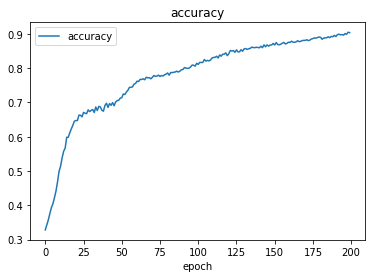

In [39]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

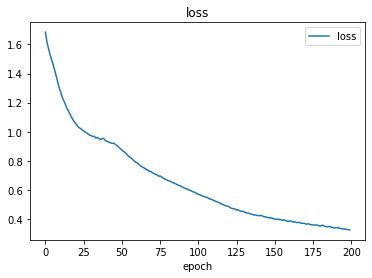

In [40]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

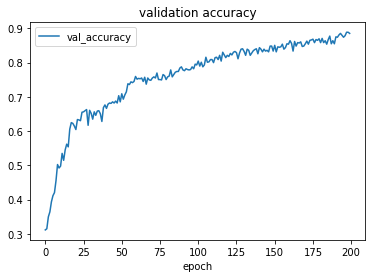

In [41]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [42]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

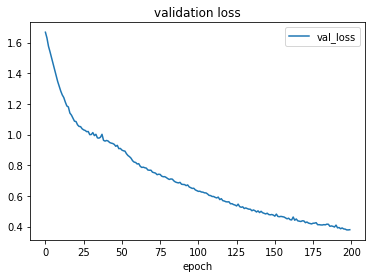

In [43]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

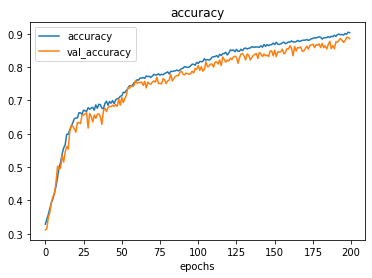

In [44]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [45]:
# individually test for predictions on single point/group of points
point = np.array(data_players_test)
prediction = model.predict_classes(point)
count = 0
total = 0
for i in range(len(data_players_test)):
    if (pos_index_test[i] == prediction[i]):
        count += 1
    total += 1
print(count/total)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index_test)

0.901010101010101
Predicted Classes: [1 1 2 0 3 3 3 3 5 3 2 2 3 2 1 2 3 2 2 2 1 3 4 1 0 3 3 3 2 1 0 1 4 3 0 3 3
 3 2 1 3 3 3 1 2 0 3 2 3 5 2 3 1 3 0 2 1 5 2 3 4 3 2 3 5 0 4 3 4 3 0 2 3 5
 3 3 4 4 3 2 0 2 0 3 0 4 3 1 2 1 4 3 3 3 3 3 4 2 1 3 1 3 1 2 1 2 0 2 0 2 5
 0 2 3 3 5 0 3 1 4 3 0 3 1 2 0 1 1 3 3 3 1 3 1 3 1 1 1 3 3 4 3 3 2 0 1 1 3
 1 3 2 2 3 3 0 3 3 3 3 0 2 2 0 2 1 3 2 5 1 2 4 3 2 5 2 1 1 2 3 5 4 3 1 4 1
 3 3 3 3 4 3 3 3 3 0 5 1 3 0 3 2 4 0 3 3 3 1 2 1 2 3 3 2 3 3 1 3 2 3 3 3 0
 3 2 4 0 3 1 1 0 3 4 2 0 3 2 1 3 2 0 1 0 0 0 0 1 3 1 2 4 2 0 1 3 3 1 3 2 1
 1 5 5 1 1 2 3 3 0 1 2 3 3 1 1 3 3 4 0 3 3 3 3 3 3 2 3 5 4 1 4 0 3 3 2 4 3
 2 4 1 0 4 0 3 4 1 3 0 0 3 1 3 1 1 4 1 3 2 3 0 3 3 3 4 0 1 1 3 0 3 5 1 3 3
 2 1 3 3 4 5 0 4 3 2 3 4 3 3 3 3 3 0 3 0 2 2 3 0 3 2 2 3 2 3 4 2 3 3 2 2 2
 2 2 3 3 4 4 2 4 3 4 0 3 3 3 3 2 4 1 0 2 2 3 3 2 1 1 2 1 3 2 4 3 3 3 2 3 3
 4 2 4 2 3 1 3 2 1 0 5 4 5 4 3 4 4 1 0 4 0 3 3 1 4 3 3 4 4 3 1 4 1 3 0 2 0
 3 3 1 2 2 2 1 2 4 4 3 1 0 3 5 1 4 3 3 2 2 2 4 0 3 2 5 5 5 1 1 

In [46]:
#Again no 4s or 5s

# Attempting to classify every position

In [48]:
rb = (raw_data.loc[raw_data['position'] == 'RB']).to_numpy()
fb = (raw_data.loc[raw_data['position'] == 'FB']).to_numpy()
wr = (raw_data.loc[raw_data['position'] == 'WR']).to_numpy()
te = (raw_data.loc[raw_data['position'] == 'TE']).to_numpy()
fs = (raw_data.loc[raw_data['position'] == 'FS']).to_numpy()
ss = (raw_data.loc[raw_data['position'] == 'SS']).to_numpy()
cb = (raw_data.loc[raw_data['position'] == 'CB']).to_numpy()
ot = (raw_data.loc[raw_data['position'] == 'OT']).to_numpy()
og = (raw_data.loc[raw_data['position'] == 'OG']).to_numpy()
oc = (raw_data.loc[raw_data['position'] == 'OC']).to_numpy()
c = (raw_data.loc[raw_data['position'] == 'C']).to_numpy()
nt = (raw_data.loc[raw_data['position'] == 'NT']).to_numpy()
dt = (raw_data.loc[raw_data['position'] == 'DT']).to_numpy()
de = (raw_data.loc[raw_data['position'] == 'DE']).to_numpy()
ls = (raw_data.loc[raw_data['position'] == 'LS']).to_numpy()
ilb = (raw_data.loc[raw_data['position'] == 'ILB']).to_numpy()
olb = (raw_data.loc[raw_data['position'] == 'OLB']).to_numpy()
qb = (raw_data.loc[raw_data['position'] == 'QB']).to_numpy()
p = (raw_data.loc[raw_data['position'] == 'P']).to_numpy()
k = (raw_data.loc[raw_data['position'] == 'K']).to_numpy()

#Trying all parameters and all positions independently!

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['year', 'heightfeet', 
            'heightinches', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic', 'nflgrade'] #all strings removed

parametersnew = ['year', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic','nflgrade']


#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        if (count == 0):   #sometimes there are no parameter stats for a certain position
            paramMeans.append(0)
        else:
            paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        
rb = (raw_data.loc[raw_data['position'] == 'RB']).to_numpy()
fb = (raw_data.loc[raw_data['position'] == 'FB']).to_numpy()
wr = (raw_data.loc[raw_data['position'] == 'WR']).to_numpy()
te = (raw_data.loc[raw_data['position'] == 'TE']).to_numpy()
fs = (raw_data.loc[raw_data['position'] == 'FS']).to_numpy()
ss = (raw_data.loc[raw_data['position'] == 'SS']).to_numpy()
cb = (raw_data.loc[raw_data['position'] == 'CB']).to_numpy()
ot = (raw_data.loc[raw_data['position'] == 'OT']).to_numpy()
og = (raw_data.loc[raw_data['position'] == 'OG']).to_numpy()
oc = (raw_data.loc[raw_data['position'] == 'OC']).to_numpy()
c = (raw_data.loc[raw_data['position'] == 'C']).to_numpy()
nt = (raw_data.loc[raw_data['position'] == 'NT']).to_numpy()
dt = (raw_data.loc[raw_data['position'] == 'DT']).to_numpy()
de = (raw_data.loc[raw_data['position'] == 'DE']).to_numpy()
ls = (raw_data.loc[raw_data['position'] == 'LS']).to_numpy()
ilb = (raw_data.loc[raw_data['position'] == 'ILB']).to_numpy()
olb = (raw_data.loc[raw_data['position'] == 'OLB']).to_numpy()
qb = (raw_data.loc[raw_data['position'] == 'QB']).to_numpy()
p = (raw_data.loc[raw_data['position'] == 'P']).to_numpy()
k = (raw_data.loc[raw_data['position'] == 'K']).to_numpy()

preprocess_data(rb, 0)
preprocess_data(fb, 1)
preprocess_data(wr, 2)
preprocess_data(te, 3)
preprocess_data(fs, 4)
preprocess_data(ss, 5)
preprocess_data(cb, 6)
preprocess_data(ot, 7)
preprocess_data(og, 8)
preprocess_data(oc, 9)
preprocess_data(c, 10)
preprocess_data(nt, 11)
preprocess_data(dt, 12)
preprocess_data(de, 13)
preprocess_data(ls, 14)
preprocess_data(ilb, 15)
preprocess_data(olb, 16)
preprocess_data(qb, 17)
preprocess_data(p, 18)
preprocess_data(k, 19)

c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
data_players_test = data_players[int(round(len(data_players) * 0.9)):]
data_players = data_players[:int(round(len(data_players) * 0.9))]
pos_index_test = pos_index[int(round(len(pos_index) * 0.9)):]
pos_index = pos_index[:int(round(len(pos_index) * 0.9))]
pos_cat = to_categorical(pos_index, 20)
print(data_players)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

[[ 4.80479734e-02  0.00000000e+00 -2.88422139e-03 -2.27561444e-03
  -1.05263422e-01  7.99812282e-01  2.38035929e-01 -3.47533695e-03
   0.00000000e+00  4.20490636e-02  2.45708948e-03  1.83744256e-01
  -1.16049100e-01 -1.90299750e-01 -8.39318477e-02 -1.62325319e-02
   2.69929650e-01 -3.28938476e-01  0.00000000e+00  1.28982755e-01]
 [-6.62889959e-02 -2.57980371e-03  1.46382988e-02 -1.36443426e-02
   5.79857866e-02  2.40430660e-01  7.18368287e-02  2.99387905e-05
   2.00731128e-02  1.21656538e-02 -1.18384111e-03  5.48181082e-02
   1.06201109e-02 -1.98770056e-02  1.53407086e-01  3.08296903e-02
   1.51369810e-01  9.19631136e-01  1.73138843e-01  4.13295374e-02]
 [-3.55404734e-02  0.00000000e+00 -4.95063183e-03 -4.95063183e-03
   4.09833556e-02  1.96904433e-01  5.76980376e-02  1.08139133e-03
   1.55722687e-02  9.47650242e-03  2.57564731e-02  4.22212636e-02
   1.93268174e-01  6.66724896e-01  4.27131430e-02  2.24567391e-02
   1.07212819e-01  6.61366489e-01  1.34243696e-01  3.16752265e-02]
 [-3.95

In [50]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=200, batch_size = 100, shuffle=True)

Train on 3560 samples, validate on 890 samples
Epoch 1/200
3560/3560 [==============================] - 0s 34us/step - loss: 2.7673 - accuracy: 0.1053 - val_loss: 2.6190 - val_accuracy: 0.1562
Epoch 2/200
3560/3560 [==============================] - 0s 9us/step - loss: 2.5575 - accuracy: 0.1461 - val_loss: 2.4822 - val_accuracy: 0.1843
Epoch 3/200
3560/3560 [==============================] - 0s 9us/step - loss: 2.3960 - accuracy: 0.2256 - val_loss: 2.3198 - val_accuracy: 0.2551
Epoch 4/200
3560/3560 [==============================] - 0s 9us/step - loss: 2.2415 - accuracy: 0.2612 - val_loss: 2.1928 - val_accuracy: 0.2820
Epoch 5/200
3560/3560 [==============================] - 0s 8us/step - loss: 2.1373 - accuracy: 0.2817 - val_loss: 2.1165 - val_accuracy: 0.3079
Epoch 6/200
3560/3560 [==============================] - 0s 9us/step - loss: 2.0596 - accuracy: 0.3093 - val_loss: 2.0492 - val_accuracy: 0.3292
Epoch 7/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.988

Epoch 57/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.5392 - accuracy: 0.8399 - val_loss: 0.6829 - val_accuracy: 0.7831
Epoch 58/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.5314 - accuracy: 0.8433 - val_loss: 0.6747 - val_accuracy: 0.8236
Epoch 59/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.5230 - accuracy: 0.8494 - val_loss: 0.6646 - val_accuracy: 0.8034
Epoch 60/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5256 - accuracy: 0.8407 - val_loss: 0.6637 - val_accuracy: 0.8337
Epoch 61/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.5153 - accuracy: 0.8478 - val_loss: 0.6629 - val_accuracy: 0.8225
Epoch 62/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.5072 - accuracy: 0.8463 - val_loss: 0.6618 - val_accuracy: 0.8022
Epoch 63/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.5008 - accuracy: 0.8517 - val_loss: 0.6482

3560/3560 [==============================] - 0s 8us/step - loss: 0.3321 - accuracy: 0.9025 - val_loss: 0.5194 - val_accuracy: 0.8213
Epoch 114/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3266 - accuracy: 0.9051 - val_loss: 0.4961 - val_accuracy: 0.8663
Epoch 115/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3241 - accuracy: 0.9149 - val_loss: 0.4860 - val_accuracy: 0.8910
Epoch 116/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3280 - accuracy: 0.9011 - val_loss: 0.4912 - val_accuracy: 0.8719
Epoch 117/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3241 - accuracy: 0.9037 - val_loss: 0.4937 - val_accuracy: 0.8787
Epoch 118/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.3217 - accuracy: 0.9107 - val_loss: 0.4845 - val_accuracy: 0.8888
Epoch 119/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3205 - accuracy: 0.9062 - val_loss: 0.4970 - val_ac

Epoch 169/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2451 - accuracy: 0.9340 - val_loss: 0.4278 - val_accuracy: 0.9067
Epoch 170/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2440 - accuracy: 0.9323 - val_loss: 0.4300 - val_accuracy: 0.9079
Epoch 171/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2454 - accuracy: 0.9278 - val_loss: 0.4345 - val_accuracy: 0.9045
Epoch 172/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2427 - accuracy: 0.9331 - val_loss: 0.4315 - val_accuracy: 0.8955
Epoch 173/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2410 - accuracy: 0.9320 - val_loss: 0.4306 - val_accuracy: 0.9034
Epoch 174/200
3560/3560 [==============================] - 0s 8us/step - loss: 0.2353 - accuracy: 0.9399 - val_loss: 0.4286 - val_accuracy: 0.9056
Epoch 175/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.2411 - accuracy: 0.9329 - val_loss: 0

In [51]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

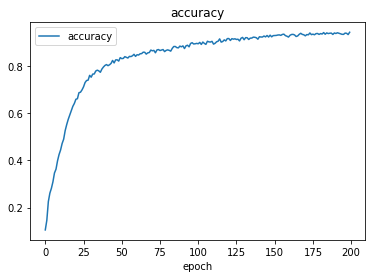

In [52]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

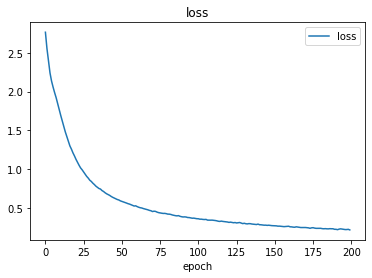

In [53]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

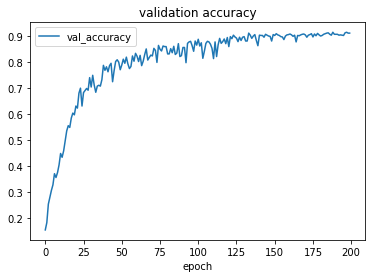

In [54]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [55]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

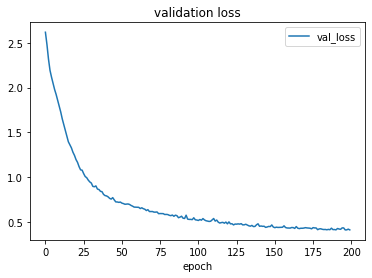

In [56]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

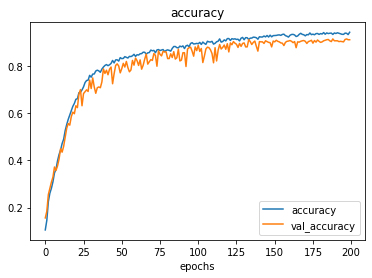

In [57]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [58]:
# individually test for predictions on single point/group of points
point = np.array(data_players_test)
prediction = model.predict_classes(point)
count = 0
total = 0
for i in range(len(data_players_test)):
    if (pos_index_test[i] == prediction[i]):
        count += 1
    total += 1
print(count/total)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index_test)

0.898989898989899
Predicted Classes: [ 2  6  2 15  2 12  7  2  7  7 12  2  6 16  2  8 10  3  3  4  2  8  2  4
  0  8  4  6  7  7 17  6 16  0  2  5  7  6  8  9  3 17  6 12  3 15  2  2
  1 13  7  2  6  6 17 13 13 16  2 10 17 10 15  6  4  2  4  1 12  7  7  4
 12  6  1 16 17 13 19 13  0  7  7  2  5  2  8  5 12 10 16 17 15  6  1  2
  2  6 13  1  0  8  7  6  4  0  9  6  2  2  8 12  7 16  6  8 18 16  2  7
 16  7 16  0 12 12 12  2  2 17  7  6 13  4 13 12  3  0  2  0 12  0  0  6
  6  1  2  2  2 15  4  7  0  7  2  2  0  9 13 16  6  9  6  7  3  3 12  3
  5 15  2  0 17  4  6  2  4 16 13 15 16  7  9 13  7 17  2  6 15  8  1  6
  2  1  4 13  0 15 12 13  7  2 12  0  6  3 16  2 13  3 12  2  6  4 12 17
 12  6  9  6  8  9  7  2  6 16 16 17 16  7 13 13 13 12  2 17  3  0 13  5
  2 12 12 16  2  7  8 17  1  8  9  5  6  4  6  6  6  7  6 12 16 13  5  2
 16  5  7  7  9  8  2  3  2 17  0  8  6 15 15 15  2  4  4 13  6  6 15  5
  6 17  2 12  7 12  3  5  8  0  6 13  6  4 12 17  5 10  8 16  6 16  2  0
  0 15  6  2  